### week 7


In [1]:
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats 

In [3]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.tile_providers import STAMEN_TERRAIN
output_notebook()

import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Hot, viridis
from datashader.utils import export_image
from datashader.bokeh_ext import InteractiveImage

from functools import partial

import param
import paramnb
%matplotlib inline
import matplotlib.pyplot as plt

Loading BokehJS ...

C:\Anaconda3\lib\site-packages\odo\backends\pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [4]:
%%time
df_main = pd.read_csv('yellow_tripdata_2016-06_ed.xz', parse_dates=['tpep_pickup_datetime'])
df_main.set_index('tpep_pickup_datetime', inplace=True)

Wall time: 46.8 s


In [5]:
df_loc = pd.read_csv('time_region_102_pickup_count.xz')
df_loc = df_loc.set_index('datetime')
df_loc = df_loc['2016-06-01':]
regions_list = df_loc.columns.astype(int)

In [6]:
# загружаем предсказания количества поездок в июне 2016
predictions = pd.read_csv('predictions_2016-06.xz')

loc = predictions['id'].str.split('_')

regions = []; dates = []; hours = []; forwards = []
for x in loc:
    regions.append(x[0])
    dates.append(x[1])
    hours.append(x[2])
    forwards.append(int(x[3]))

df = pd.DataFrame()
df['regions'] = regions
df['datetime']=  [date+' '+hour for date, hour in zip(dates, hours)]
df['predicts'] = forwards
df['datetime'] = [pd.datetime.strptime(row, '%Y-%m-%d %H') for row in df['datetime']]
df['y'] = predictions['y']
df.set_index('datetime', inplace=True)
df_june_predictions = df

In [7]:
def get_day_predicts(df, forward, region=None, date=None, hour=None):
    if region is not None:
        df = df[df['regions'] == str(region)]
    df = df[df['predicts'] == int(forward)]
    df.is_copy = False
    df.index = df.index + dt.timedelta(hours=1)
    if date is not None:
        df = df[date]
    if hour is not None:
        df = df[df.index.hour == hour]['y'].values
    return df

In [8]:
def get_bootstrap_samples(df_loc, predictions):
    result = {}
    for n_samples, region in zip(predictions, regions_list):
        n_samples = int(round(n_samples, 0))
        data = df_loc[df_loc['region_pickup'] == region]
        if n_samples != 0: 
            index = np.random.choice(data.shape[0], size=int(n_samples))
            row = data.iloc[index, [0,1]].values
            result[region] = row
        else:
            result[region] = [0, 0]
    pred_coords = pd.DataFrame()
    for x in result.values():
        y = pd.DataFrame(x)
        pred_coords = pd.concat([pred_coords, y])
    pred_coords.columns = ['pickup_longitude', 'pickup_latitude']
    pred_coords.index = list(range(len(pred_coords)))
    return pred_coords

In [9]:
def get_coords_df(date, hour, region=None):
    df_real = df_main[['pickup_longitude', 'pickup_latitude', 'region_pickup']].copy()
    if date is not None:
        df_real = df_real[date]
    if hour is not None:
        df_real = df_real[df_real.index.hour == hour]
    df_real = df_real[df_real['region_pickup'].isin(regions_list) ]
    if region is not None:
        df_real = df_real[df_real['region_pickup'] == region]
    df_real.drop('region_pickup', axis=1, inplace=True)
    df_real.index = list(range(len(df_real)))
    return df_real

In [10]:
def latlng_to_meters(df, lat_name, lng_name):
    lat = df[lat_name]
    lng = df[lng_name]
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = lng * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) / (np.pi / 180.0)
    my = my * origin_shift / 180.0
    df.loc[:, 'pickup_x'] = mx
    df.loc[:, 'pickup_y'] = my

In [11]:
class GetData(param.Parameterized):
    hour = param.Integer(default=3, bounds=(0,23))
    date = param.ObjectSelector(default='2016-06-01', 
       objects=np.unique([x.strftime('%Y-%m-%d') for x in  df_loc.index.astype('<M8[D]')]),
                check_on_set=True)

#### 1) карты с визуализацией реального и прогнозируемого спроса на такси в выбираемый пользователем момент времени 

In [12]:
# выберите дату, час и нажмите кнопку
paramnb.Widgets(GetData, button=True, next_n=4)

<IPython.core.display.Javascript object>

Widget Javascript not detected.  It may not be installed or enabled properly.


In [13]:
date = str(GetData.date)
hour = int(GetData.hour)
# получаем координаты реальных проездок в выбранный день и час
df_real = get_coords_df(date, hour, region=None)
df = df_june_predictions.copy()
# получаем предсказанное количество поездок в выбранный день и час (из ранее полученной модели) 
if (date == '2016-06-30') & (hour > 18):
    df = df[df['predicts'] == int(6)]
    df = df[date]
    prediction_nums = df[df.index.hour == (hour - 6)]['y']
else:
    prediction_nums = get_day_predicts(df=df, forward=1, region=None, date=date, hour=hour)
# бутстрапируем коордианты из реальной выборки поячеечно для предсказанного количеста поездок в каждой ячейке
df_pred = get_bootstrap_samples(df_main, prediction_nums)
# добавляем в файл данные в метрах для получения карт ниже
latlng_to_meters(df_real, 'pickup_latitude', 'pickup_longitude')
latlng_to_meters(df_pred, 'pickup_latitude', 'pickup_longitude')

In [14]:
NY = x_range, y_range = ((df_real['pickup_x'].min(), df_real['pickup_x'].max()), 
                          (df_real['pickup_y'].min(), df_real['pickup_y'].max()))

plot_width  = 900
plot_height = 900

def base_plot(tools='pan, box_zoom, wheel_zoom, save, reset', 
              plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

def create_image_pred(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df_pred, 'pickup_x', 'pickup_y')
    img = tf.shade(agg.where(agg>np.percentile(agg,90)), cmap=viridis, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

def create_image_real(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df_real, 'pickup_x', 'pickup_y')
    img = tf.shade(agg.where(agg>np.percentile(agg,90)), cmap=viridis, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

In [15]:
# карта с визуализацией реального спроса
export = partial(export_image, export_path="export")
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
export(create_image_real(*NY), "NY1")
InteractiveImage(p, create_image_real)

In [16]:
# карта с визуализацией предсказанного спроса
export = partial(export_image, export_path="export")
p = base_plot()
p.add_tile(STAMEN_TERRAIN)
export(create_image_pred(*NY), "NY2")
InteractiveImage(p, create_image_pred)

#### 2) временной ряд фактического и прогнозируемого спроса на такси в выбираемой области.

In [17]:
class GetCell(param.Parameterized):
    cell = param.ObjectSelector(default=regions_list[0], objects=regions_list, check_on_set=True)

In [18]:
from sklearn.metrics import mean_absolute_error

In [19]:
# выберите интересующую ячейку (регион) и намите на кнопку
paramnb.Widgets(GetCell, button=True, next_n=2)

<IPython.core.display.Javascript object>

Widget Javascript not detected.  It may not be installed or enabled properly.


In [20]:
region = GetCell.cell
# получаем предсказанное количество поездок в выбранный день и час (из ранее полученной модели) 
df = df_june_predictions.copy()
df = df[df['regions'] == str(region)]
df1 = df[df['predicts'] == int(1)].copy()
df2 = df[df['predicts'] == int(6)].copy()
df = pd.concat([df1, df2[-5:]], axis=0)
prediction_nums = df
hours = pd.date_range('2016-06-01 00:00:00', periods=720, freq='H')
prediction_nums.index = hours
pred_arr = prediction_nums['y'].values
real_arr = df_loc.loc[:,str(region)].values

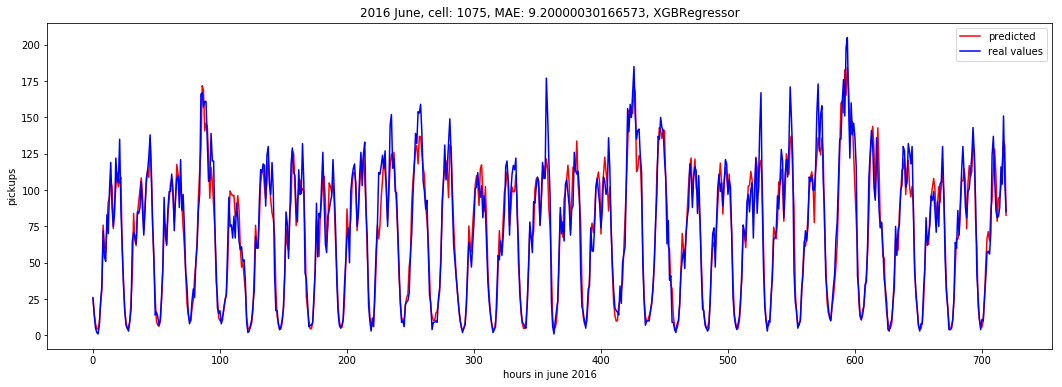

In [21]:
plt.figure(figsize=(18,6))
plt.plot(pred_arr, 'r', label='predicted')
plt.plot(real_arr, 'b', label='real values')
plt.title('2016 June, cell: {}, MAE: {}, XGBRegressor'.format(region, mean_absolute_error(real_arr, pred_arr)))
plt.ylabel('pickups')
plt.xlabel('hours in june 2016')
plt.legend()
plt.show()